# Semi-supervised Learning with Deep Generative Models

https://arxiv.org/abs/1406.5298

In [1]:
using Flux
using CuArrays
using Plots
using Plots.PlotMeasures
pyplot()

Plots.PyPlotBackend()

## MNIST Dataset

In [2]:
MNISTspec = (
    input_size = (28, 28, 1),
    num_classes = 10,
    train_size = 60000,
    test_size = 10000,
)

(input_size = (28, 28, 1), num_classes = 10, train_size = 60000, test_size = 10000)

In [3]:
function load_mnist(split=:train)
    mnist = Flux.Data.MNIST
    
    images = mnist.images(split) # Array with N images of 28x28 8-bits gray
    labels = mnist.labels(split) # Array with N labels scalar 0-9
    
    return images, labels
end

X, y = load_mnist()

println("X: type=$(typeof(X)), size=$(size(X))")
println("y: type=$(typeof(y)), size=$(size(y))")

X: type=Array{Array{Gray{FixedPointNumbers.Normed{UInt8,8}},2},1}, size=(60000,)
y: type=Array{Int64,1}, size=(60000,)


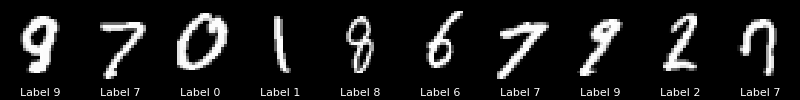

In [4]:
plot_digit(x, y) = plot(x, xlabel= y!==nothing ? "Label $(y)" : "",
                        guidefontsize=8, legend=false, margin=0mm, link=:both,
                        ticks=nothing, border=:none)
function plot_digits(x, y=nothing; size=(800, 100), layout=(1, length(x)))
    plots = map(1:prod(layout)) do i
        xi = x[i]
        yi = y !== nothing ? y[i] : nothing
        plot_digit(xi, yi)
    end
    plot(plots..., layout=layout, size=size, bg_color="black", fg_color="white")
end

sample_indices = rand(1:MNISTspec.train_size, 10)
plot_digits(X[sample_indices], y[sample_indices])

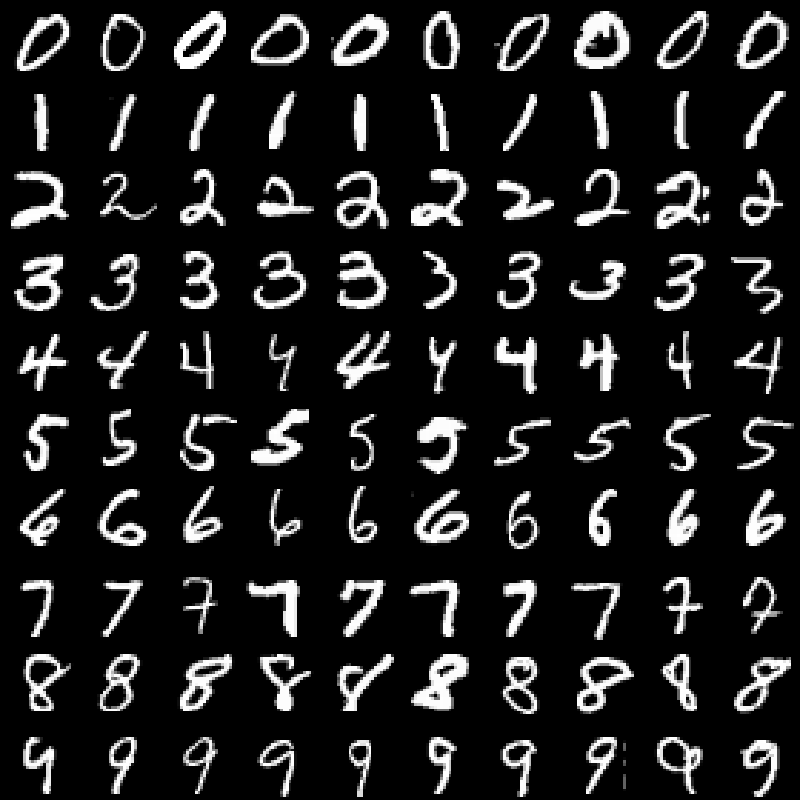

In [5]:
function sample_classes(y, sample_size)
    num_classes = MNISTspec.num_classes
    sample_size % num_classes != 0 && error("Sample size must be multiple of $(num_classes)")
    n = sample_size ÷ MNISTspec.num_classes
    samples = Vector{Int}()
    for y_=0:(num_classes-1)
        y_indices = findall(yi -> yi == y_, y)
        y_sample = rand(y_indices, n)
        append!(samples, y_sample)
    end
    return samples
end

sample100 = sample_classes(y, 100)
plot_digits(X[sample100]; size=(800, 800), layout=(10, 10))

In [ ]:
using Flux.Data.MNIST

# Load data, binarise it, and partition into mini-batches of M.
X = float.(hcat(vec.(MNIST.images())...)) .> 0.5
N, M = size(X, 2), 100
data = [X[:,i] for i in Iterators.partition(1:N,M)];

size(data)

In [ ]:
# Extend distributions slightly to have a numerically stable logpdf for `p` close to 1 or 0.
using Distributions
import Distributions: logpdf
logpdf(b::Bernoulli, y::Bool) = y * log(b.p + eps(Float32)) + (1f0 - y) * log(1 - b.p + eps(Float32))

In [ ]:
################################# Define Model #################################

using Flux

# Latent dimensionality, # hidden units.
Dz, Dh = 5, 500

# Components of recognition model / "encoder" MLP.
A, μ, logσ = Dense(28^2, Dh, tanh), Dense(Dh, Dz), Dense(Dh, Dz)
g(X) = (h = A(X); (μ(h), logσ(h)))
z(μ, logσ) = μ + exp(logσ) * randn(Float32)

# Generative model / "decoder" MLP.
f = Chain(Dense(Dz, Dh, tanh), Dense(Dh, 28^2, σ))

In [ ]:
####################### Define ways of doing things with the model. #######################

# KL-divergence between approximation posterior and N(0, 1) prior.
kl_q_p(μ, logσ) = 0.5f0 * sum(exp.(2f0 .* logσ) + μ.^2 .- 1f0 .- (2 .* logσ))

# logp(x|z) - conditional probability of data given latents.
logp_x_z(x, z) = sum(logpdf.(Bernoulli.(f(z)), x))

# Monte Carlo estimator of mean ELBO using M samples.
L̄(X) = ((μ̂, logσ̂) = g(X); (logp_x_z(X, z.(μ̂, logσ̂)) - kl_q_p(μ̂, logσ̂)) * 1 // M)

loss(X) = -L̄(X) + 0.01f0 * sum(x->sum(x.^2), params(f))

# Sample from the learned model.
modelsample() = rand.(Bernoulli.(f(z.(zeros(Dz), zeros(Dz)))))

In [ ]:
################################# Learn Parameters ##############################

using Flux: throttle, params

evalcb = throttle(() -> @show(-L̄(X[:, rand(1:N, M)])), 30)
opt = ADAM()
ps = params(A, μ, logσ, f)

for i = 1:10
  @info "Epoch $i"
  Flux.train!(loss, ps, zip(data), opt, cb=evalcb)
end

In [ ]:
################################# Sample Output ##############################

using Images

img(x) = Gray.(reshape(x, 28, 28))

cd(@__DIR__)
sample = hcat(img.([modelsample() for i = 1:10])...)
save("sample.png", sample)